## Now for the Analysis
After lots of munging, I have a dataframe containing text of all the presidential inaugural addresses, along with metadata like date, wordcounts, party affilations, and etc.

First we open the dataframe

In [1]:
import pandas as pd
inaugurals = pd.read_csv('./data/inaugurals_complete.csv')
inaugurals.head()


,urls,years,pres,texts,wordcounts,party,change,new counts
0,http://avalon.law.yale.edu/18th_century/wash1.asp,1789,George Washington,"of THE CITY OF NEW YORK THURSDAY, APRIL 3...",1443.0,Federalist,New_Party,1443
1,http://avalon.law.yale.edu/18th_century/wash2.asp,1793,George Washington,"of THE CITY OF PHILADELPHIA MONDAY, MARCH...",149.0,Federalist,Incumbent_Party,149
2,http://avalon.law.yale.edu/18th_century/adams.asp,1797,John Adams,© 2008 Lillian Goldman Law Library 127 Wall St...,2417.0,Democratic-Republican,New_Party,2417
3,http://avalon.law.yale.edu/19th_century/jefina...,1801,Thomas Jefferson,"March 4, 1801 FRIENDS AND FELLOW-...",1742.0,Democratic-Republican,Incumbent_Party,1742
4,http://avalon.law.yale.edu/19th_century/jefina...,1805,Thomas Jefferson,"March 4, 1805 Proceeding, fellow citi...",2162.0,Democratic-Republican,Incumbent_Party,2162


In [2]:
import os, csv, math
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer



## Now do some basic word-counting, using Ted's functions from Week 4

In [3]:
def tokenize(astring):
    ''' Breaks a string into words, and counts them.
    Designed so it strips punctuation and lowercases everything,
    but doesn't separate hashtags and at-signs.
    '''
    wordcounts = Counter()
    # create a counter to hold the counts
    
    tokens = astring.split()
    for t in tokens:
        word = t.strip(',.!?:;-—()<>[]/"\'').lower()
        wordcounts[word] += 1
        
    return wordcounts

def addcounters(counter2add, countersum):
    ''' Adds all the counts in counter2add to countersum.
    Because Counters(like dictionaries) are mutable, it
    doesn't need to return anything.
    '''
    
    for key, value in counter2add.items():
        countersum[key] += value

def create_vocab(seq_of_strings, n):
    ''' Given a sequence of text snippets, this function
    returns the n most common words. We'll use this to
    create a limited 'vocabulary'.
    '''
    vocab = Counter()
    for astring in seq_of_strings:
        counts = tokenize(astring)
        addcounters(counts, vocab)
    topn = [x[0] for x in vocab.most_common(n)]
    return topn

# Let's test the vocabulary function.
vocab = create_vocab(inaugurals['texts'], 4000)
vocab[0:10]
        

['the', 'of', 'and', 'to', 'in', 'a', 'our', 'that', 'we', 'be']

In [4]:
def logodds(countsA, countsB, word):
    ''' Straightforward.
    '''
    
    odds = (countsA[word] + 1) / (countsB[word] + 1)
    
    # Why do we add 1 on both sides? Two reasons. The hacky one is 
    # that otherwise we'll get a division-by-zero error whenever
    # word isn't present in countsB. The more principled reason
    # is that this technique (called Laplacian smoothing) tends
    # to reduce the dramatic disproportion likely to be found in
    # very rare words.
    
    return math.log(odds)

def signed_dunnings(countsA, totalA, countsB, totalB, word):
    ''' Less straightforward. This function calculates a signed (+1 / -1)
    version of Dunning's log likelihood. Intuitively, this is a number 
    that gets larger as the frequency of the word in our two corpora
    diverges from its EXPECTED frequency -- i.e., the frequency it would
    have if it were equally distributed over both. But it also tends to get
    larger as the raw frequency of the word increases.
    
    Note that this function requires two additional arguments:
    the total number of words in A and B. We could calculate that inside
    the function, but it's faster to calculate it just once, outside the function.
    
    Also note: the strict definition of Dunnings has no 'sign': it gets bigger
    whether a word is overrepresented in A or B. I've edited that so that Dunnings
    is positive if overrepresented in A, and negative if overrepresented in B.
    '''
    if word not in countsA and word not in countsB:
        return 0
    
    # the raw frequencies of this word in our two corpora
    # still doing a little Laplacian smoothing here
    a = countsA[word] + 0.1
    b = countsB[word] + 0.1
    
    # now let's calculate the expected number of times this
    # word would occur in both if the frequency were constant
    # across both
    overallfreq = (a + b) / (totalA + totalB)
    expectedA = totalA * overallfreq
    expectedB = totalB * overallfreq
    
    # and now the Dunning's formula
    dunning = 2 * ((a * math.log(a / expectedA)) + (b * math.log(b / expectedB)))
    
    if a < expectedA:
        return -dunning
    else:   
        return dunning

# a set of common words is often useful
stopwords = {'a', 'an', 'are', 'and', 'but', 'or', 'that', 'this', 'so', 
             'all', 'at', 'if', 'in', 'i', 'is', 'was', 'by', 'of', 'to', 
             'the', 'be', 'you', 'were'}

# finally, one more function: given a list of tuples like
testlist = [(10, 'ten'), (2000, 'two thousand'), (0, 'zero'), (-1, 'neg one'), (8, 'eight')]
# we're going to want to sort them and print the top n and bottom n

def headandtail(tuplelist, n):
    tuplelist.sort(reverse = True)
    print("TOP VALUES:")
    for i in range(n):
        print(tuplelist[i][1], tuplelist[i][0])
    
    print()
    print("BOTTOM VALUES:")
    lastindex = len(tuplelist) - 1
    for i in range(lastindex, lastindex - n, -1):
        print(tuplelist[i][1], tuplelist[i][0])
        
headandtail(testlist, 2)
    

TOP VALUES:
two thousand 2000
ten 10

BOTTOM VALUES:
neg one -1
zero 0


In [5]:
# Code for Exercise 1

# Start by creating a vocabulary for words in the Trump tweets.
# Put it in a variable called 'vocab'.

inaugural_text = inaugurals['texts']
vocab = create_vocab(inaugural_text, 5000)
vocab[:10]

# Remember the function create_vocab takes two arguments:
# (seq_of_strings, n)
# We can afford to include all the words, so set n for 5000.


# An optional step: removing stopwords
vocab = list(set(vocab) - stopwords)

# Create counters for the different corpora.

Democrat = Counter()
Republican = Counter()

New_Party = Counter()
Incumbent_Party = Counter()

# Figure out how many rows are in the inaugurals DataFrame
# and put that number in a variable like 'numrows.'
# Then iterate through the 'text' column of the data frame.

numrows = 58

# for each text cell, get a Counter with words counts for that cell
# then add those counts either to iphone or android, like so:

for i in range(numrows):
    counts = tokenize(inaugurals['texts'][i])
    if 'Democrat' in inaugurals['party'][i]:
        addcounters(counts, Democrat)
    elif 'Republican' in inaugurals['party'][i]:
        addcounters(counts, Republican)
        
for i in range(numrows):
    counts2 = tokenize(inaugurals['texts'][i])
    if 'New_Party' in inaugurals['change'][i]:
        addcounters(counts2, New_Party)
    elif 'Incumbent_Party' in inaugurals['change'][i]:
        addcounters(counts2, Incumbent_Party)

        

total_democrat = sum(Democrat.values())
total_republican = sum(Republican.values())

total_new_party = sum(New_Party.values())
total_incumbent_party = sum(Incumbent_Party.values()) 

# Create an empty list to hold pairs of (overrepresentation_measure, word)
# Then iterate through your vocabulary. For each word, measure 
# overrepresentation using either logodds or signed_dunnings.
# Create a tuple, (overrepresentation_measure, word)
# and append it to the empty list you created.

new_list = []
for word in vocab:
#     g = logodds(Republican, Democrat, word)
    g = signed_dunnings(Republican, total_republican, Democrat, total_democrat, word)
    new_list.append((g, word))
    

# Finally use the headandtail function to display the top 25 and bottom 25
# words in your tuplelist.
headandtail(new_list, 20)

TOP VALUES:
law 37.85900298929792
business 32.87730435677244
enforcement 27.661956717563825
there 26.71258693822815
no 21.023840498701418
we 20.368952478920193
freedom 19.949151468604846
will 19.711108571025164
make 19.27829134912094
do 18.29887958039273
negro 17.7213002579283
amendment 17.662006465968325
accept 17.01798088257794
congress 16.84090924743422
america 16.585253111580684
method 14.88972168638792
islands 14.88972168638792
arbitration 14.88972168638792
south 14.304357332097728
prayer 13.7751544999991

BOTTOM VALUES:
which -25.587694865809624
been -24.768251604369084
powerful -24.257396715885317
powers -20.639945618320855
union -19.808186401517098
myself -19.68520084932692
me -19.212377774373138
foreign -18.94148581831667
my -18.87101149359202
 -18.74433136968643
on -18.413088656786343
opinion -16.987689023401476
happy -16.890688937556916
fellow-citizens -16.81270986608169
spirit -16.686359964373743
period -16.515374263165533
limits -16.276798224583224
measures -15.84649594417

In [6]:
# Same analysis for new party vs. incumbent
new_list2 = []
for word in vocab:
#     g = logodds(New_Party, Incumbent_Party, word)
    g = signed_dunnings(New_Party, total_new_party, Incumbent_Party, total_incumbent_party, word)
    new_list2.append((g, word))
    

# Finally use the headandtail function to display the top 25 and bottom 25
# words in your tuplelist.
headandtail(new_list2, 20)

# For some reason this is producing no results-- just the alphabetical lists

TOP VALUES:
no 40.010360839571774
constitution 19.577183734933826
 17.931348691388653
any 15.31785498849851
begin 13.453571167017348
renewal 13.3841728148344
intention 13.3841728148344
used 13.243797527541663
granted 13.065175433275572
your 12.248297357165058
idea 12.059801735588124
texas 11.878578153355718
yours 11.637758545227527
roman 11.637758545227527
productivity 11.637758545227527
normal 11.637758545227527
where 11.605446336355595
sides 10.698035676444896
confederacy 9.931003754879121
summoned 9.89529541422471

BOTTOM VALUES:
progress -24.00508783065498
four -18.336076540023946
years -18.19748242677882
treaty -17.547902118867498
importance -17.35348133272472
coast -17.119917225376554
peace -15.179756738995941
useful -15.019386538779992
self-government -14.705635580733066
conditions -14.172138017324118
force -13.668582677063124
improvement -12.928550549993723
mighty -12.922372117613767
negro -12.922372117613767
determined -12.632841462979192
war -12.339013840414829
nations -12.06

## Unsupervised learning
Let's see if we can get the computer to separate out all of these political parties via unsupervised processing.

In [9]:
%matplotlib inline
import os, csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# pd.options.mode.chained_assignment = None

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS

unsup_inaug = pd.read_csv('./data/inaugurals_complete.csv')

# let's make the date column numeric
unsup_inaug['years'] = pd.to_numeric(unsup_inaug['years'], errors='coerce')

# and create a numeric column to identify them.
parties = unsup_inaug.party.unique()
parties = parties.tolist()
party_indices = []
for party in unsup_inaug['party']:
    idx = parties.index(party)
    party_indices.append(idx)
unsup_inaug['party_indices'] = party_indices

# also create a numeric column to identify the incumbent vs. newcomers
changes = unsup_inaug.change.unique()
incumbs = changes.tolist()
print(incumbs)
change_indices = []
for change in unsup_inaug['change']:
    # A slight data munge necessary here to pull out an errant comma in my df.
    if change == 'New_Party,':
        change = 'New_Party'
    idx = incumbs.index(change)
    change_indices.append(idx)
unsup_inaug['change_indices'] = change_indices

unsup_inaug.head()


['New_Party', 'Incumbent_Party', 'New_Party,']


,urls,years,pres,texts,wordcounts,party,change,new counts,party_indices,change_indices
0,http://avalon.law.yale.edu/18th_century/wash1.asp,1789,George Washington,"of THE CITY OF NEW YORK THURSDAY, APRIL 3...",1443.0,Federalist,New_Party,1443,0,0
1,http://avalon.law.yale.edu/18th_century/wash2.asp,1793,George Washington,"of THE CITY OF PHILADELPHIA MONDAY, MARCH...",149.0,Federalist,Incumbent_Party,149,0,1
2,http://avalon.law.yale.edu/18th_century/adams.asp,1797,John Adams,© 2008 Lillian Goldman Law Library 127 Wall St...,2417.0,Democratic-Republican,New_Party,2417,1,0
3,http://avalon.law.yale.edu/19th_century/jefina...,1801,Thomas Jefferson,"March 4, 1801 FRIENDS AND FELLOW-...",1742.0,Democratic-Republican,Incumbent_Party,1742,1,1
4,http://avalon.law.yale.edu/19th_century/jefina...,1805,Thomas Jefferson,"March 4, 1805 Proceeding, fellow citi...",2162.0,Democratic-Republican,Incumbent_Party,2162,1,1


In [18]:
unsup_inaug.to_csv('data/inaugural_complete.csv', index = False)

## Make term-doc matrices
Using Ted's code, I make the following TDMs.


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# that will just give us a term-doc matrix

from sklearn.feature_extraction.text import TfidfTransformer
# normalizes by dividing each (document) row by row sum
# and then adjusts for inverse document frequency

from sklearn.preprocessing import StandardScaler
# normalizes by centering each column on its mean, and 
# dividing by standard deviation

# The original code is max_features = 500
countvec = CountVectorizer(max_features = 500)
# countvec = CountVectorizer(max_features= 50)
# The number of features we're using is an important choice.

sparse_counts = countvec.fit_transform(unsup_inaug['texts'])

inaug_termdoc = sparse_counts.toarray()
# a lot of these methods return a sparse matrix that needs to be
# reinflated with .toarray()

transformer = TfidfTransformer()
selected_tfidf = transformer.fit_transform(inaug_termdoc).toarray()

normalizer = StandardScaler()
selected_normed = normalizer.fit_transform(inaug_termdoc)

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
legible_tfidf = pd.DataFrame(selected_tfidf, columns=countvec.get_feature_names())
legible_tfidf.head()

,about,abroad,act,action,administration,advance,affairs,after,again,against,...,women,words,work,world,would,year,years,yet,you,your
0,0.000000,0.000000,0.009555,0.000000,0.017666,0.000000,0.009954,0.000000,0.009182,0.007354,...,0.0,0.0,0.000000,0.006082,0.006292,0.000000,0.006977,0.000000,0.039498,0.081043
1,0.067337,0.000000,0.072840,0.000000,0.067337,0.000000,0.000000,0.000000,0.069999,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068647
2,0.000000,0.007230,0.000000,0.000000,0.016076,0.000000,0.000000,0.018899,0.000000,0.004462,...,0.0,0.0,0.000000,0.011069,0.007635,0.013165,0.012699,0.000000,0.000000,0.005463
3,0.007279,0.009821,0.000000,0.000000,0.014559,0.018292,0.008203,0.000000,0.000000,0.012121,...,0.0,0.0,0.006169,0.015036,0.031114,0.000000,0.000000,0.014017,0.045571,0.051947
4,0.000000,0.000000,0.020872,0.006686,0.006432,0.008081,0.021744,0.000000,0.013372,0.032129,...,0.0,0.0,0.000000,0.008857,0.018327,0.015801,0.010161,0.012385,0.023008,0.026227


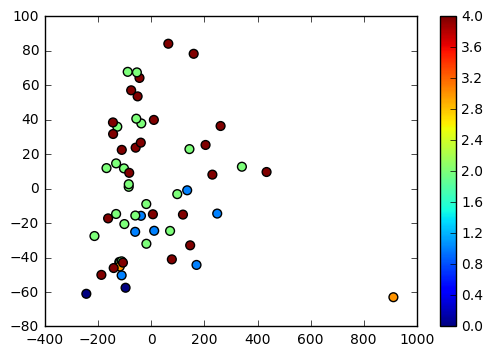

0: Federalist
1: Democratic-Republican
2: Democrat
3: Whig
4: Republican


In [14]:
pca = PCA(n_components=2)
# Create a PCA-izer.

# First run it on the straight term-doc matrix. Note that this is actually 
# normalized a bit implicitly since all text snippets in this collection 
# run to 1200 words. Otherwise passage *lengths* could create differences,
# and you would need to divide rows by row-sums.

pca_termdoc = pca.fit_transform(inaug_termdoc)
plot = plt.scatter(pca_termdoc[ : , 0], pca_termdoc[ : , 1], s = 40,
                   c = unsup_inaug['party_indices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()
for index, name in enumerate(parties):
    print(str(index) + ": " + name)

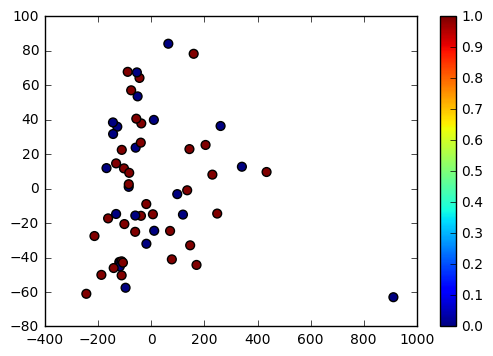

0: New_Party
1: Incumbent_Party
2: New_Party,


In [16]:
pca_termdoc = pca.fit_transform(inaug_termdoc)
plot = plt.scatter(pca_termdoc[ : , 0], pca_termdoc[ : , 1], s = 40,
                   c = unsup_inaug['change_indices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()
for index, name in enumerate(incumbs):
    print(str(index) + ": " + name)

## It doesn't really separate
The blue dots are definitely in a cluster-- I believe they are Democrat-Republican. But the Democrat and Repubican are not well separated. Likewise, I don't think the incumbent- newcomer party speeches really separate from each other in any clear way. Unsupervised learning does not succeed in recognizing and pulling apart these categories of inaugural addresses.